# 9章 潜在顧客を把握するための画像認識

ここでは、カメラから取得した映像を用いて画像認識を行い、
必要な情報を取得するための流れを学ぶことで、
画像認識をビジネス現場で応用するイメージをつかみます。

画像 Data を表示する

In [6]:
import cv2

img = cv2.imread('sample_code/chapter_9/img/img01.jpg')
height, width = img.shape[:2]
print(f'画像幅: {str(width)}')
print(f'画像高さ: {str(height)}')
cv2.imshow("img", img)
cv2.waitKey(3000)
cv2.destroyAllWindows()

画像幅: 1920
画像高さ: 1440


映像 Data を表示する

In [9]:
import cv2

# 情報取得
cap = cv2.VideoCapture('sample_code/chapter_9/mov/mov01.avi')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
print(f'画像幅: {str(width)}')
print(f'画像高さ: {str(height)}')
print(f'総フレーム数: {str(count)}')
print(f'FPS: {str(fps)}')

# 出力
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

cv2.destroyAllWindows()

画像幅: 1920.0
画像高さ: 1440.0
総フレーム数: 401.0
FPS: 30.0


映像を画像に分割し、保存する

In [4]:
import cv2

cap = cv2.VideoCapture('sample_code/chapter_9/mov/mov01.avi')
num = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        cv2.imshow('frame', frame)
        filepath = f'snapshot/snapshot_{str(num)}.jpg'
        cv2.imwrite(filepath, frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    num = num + 1

cap.release()
cv2.destroyAllWindows()

In [8]:
import cv2

# 準備
hog = cv2.HOGDescriptor() # 宣言
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) # ヒトのモデルを与える
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold': 0, 'finalThreshold': 5}

# 検出
img = cv2.imread('sample_code/chapter_9/img/img01.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 読み込んだ画像をモノクロにする
human, r = hog.detectMultiScale(gray, **hogParams) # 人の検出を実行する
if len(human) > 0:
    for (x, y, w, h) in human:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 3) # human に格納された位置情報から四角形を描く

cv2.imshow('img', img)
cv2.waitKey(3000)
cv2.destroyAllWindows()

In [3]:
import cv2

# 準備
cascade_file = 'sample_code/chapter_9/haarcascade_frontalface_alt.xml' # 宣言 & 正面顔を認識する Model を与える。
cascade = cv2.CascadeClassifier(cascade_file)

# 検出
img = cv2.imread('sample_code/chapter_9/img/img02.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_list = cascade.detectMultiScale(gray, minSize=(50, 50)) # 顔の位置を検出

# 検出した顔に印を付ける
for (x, y, w, h) in face_list:
    color = (0, 0, 225)
    pen_w = 3
    cv2.rectangle(img, (x, y), (x + w, y + h), color, thickness=pen_w)

cv2.imshow('img', img)
cv2.imwrite('temp.jpg', img)
cv2.waitKey(3000)
cv2.destroyAllWindows()

In [5]:
import cv2
import dlib
import math

# 準備
predictor = dlib.shape_predictor('sample_code/chapter_9/shape_predictor_68_face_landmarks.dat') # 68点の顔器官 Model の読み込み
detector = dlib.get_frontal_face_detector() # 顔正面の Model の読み込み

# 検出
img = cv2.imread('sample_code/chapter_9/img/img02.jpg')
dets = detector(img, 1) # 写真から正面顔を検出

for k, d in enumerate(dets):
    shape = predictor(img, d) # 写真から検出した正面顔に含まれる68点の顔器官を検出。

    # 顔領域の表示
    color_f = (0, 0, 225)
    color_l_out = (255, 0, 0)
    color_l_in = (0, 255, 0)
    line_w = 3
    circle_r = 3
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    fontSize = 1
    cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()), color_f, line_w)
    cv2.putText(img, str(k), (d.left(), d.top()) , fontType, fontSize, color_f, line_w)

    # 重心を導出する箱を用意
    num_of_points_out = 17
    num_of_points_in = shape.num_parts - num_of_points_out
    gx_out = 0
    gy_out = 0
    gx_in = 0
    gy_in = 0
    for shape_point_count in range(shape.num_parts):
        shape_point = shape.part(shape_point_count)
        # print(f'顔器官 No. {shape_point_count} 座標位置: {shape_point.x}, {shape_point.y}')
        # 器官ごとに描画
        if shape_point_count < num_of_points_out:
            cv2.circle(img, (shape_point.x, shape_point.y), circle_r, color_l_out, line_w)
            gx_out = gx_out + shape_point.x / num_of_points_out
            gy_out = gy_out + shape_point.y / num_of_points_out
        else:
            cv2.circle(img, (shape_point.x, shape_point.y), circle_r, color_l_in, line_w)
            gx_in = gx_in + shape_point.x / num_of_points_in
            gy_in = gy_in + shape_point.y / num_of_points_in
    # 重心位置を描画
    cv2.circle(img, (int(gx_out), int(gy_out)), circle_r, (0, 0, 255), line_w)
    cv2.circle(img, (int(gx_in), int(gy_in)), circle_r, (0, 0, 0), line_w)

    # 顔の方位を計算
    theta = math.asin(2 * (gx_in - gx_out) / (d.right() - d.left()))
    radian = theta * 180 / math.pi
    print(f'顔方位: {theta}（角度: {radian}度）')

    # 顔方位を表示
    if radian < 0:
        textPrefix = '   left '
    else:
        textPrefix = '   right '
    textShow = textPrefix + str(round(abs(radian), 1)) + ' deg.'
    cv2.putText(img, textShow, (d.left(), d.top()), fontType, fontSize, color_f, line_w)


cv2.imshow('img', img)
cv2.imwrite('dump/temp_2.jpg', img)
cv2.waitKey(3000)
cv2.destroyAllWindows()

顔方位: 0.06456096931747406（角度: 3.6990710631648662度）


In [6]:
import cv2

print("Timelapse 生成を開始します")

# 映像取得 #
cap = cv2.VideoCapture("sample_code/chapter_9/mov/mov01.avi")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# hog宣言 #
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold': 0, 'finalThreshold': 5}

# Timelapse 作成 #
movie_name = "dump/timelapse.avi"
fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
video = cv2.VideoWriter(movie_name, fourcc, 30, (width, height))

num = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        if num % 10 == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            human, r = hog.detectMultiScale(gray, **hogParams)
            if len(human) > 0:
                for (x, y, w, h) in human:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 3)

            video.write(frame)
    else:
        break
    num = num + 1
video.release()
cap.release()
cv2.destroyAllWindows()
print("Timelapse 生成を終了しました")

Timelapse 生成を開始します
Timelapse 生成を終了しました


In [1]:
import cv2
import pandas as pd

print('分析を開始します')

# 映像取得
cap = cv2.VideoCapture('sample_code/chapter_9/mov/mov01.avi')
fps = cap.get(cv2.CAP_PROP_FPS)

# hog 宣言
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold': 0, 'finalThreshold': 5}

num = 0
list_df = pd.DataFrame(columns=['time', 'people'])
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        if num % 10 == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            human, r = hog.detectMultiScale(gray, **hogParams)
            if len(human) > 0:
                for (x, y, w, h) in human:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 3)
            tmp_se = pd.Series([num / fps, len(human)], index=list_df.columns)
            list_df = list_df.append(tmp_se, ignore_index=True)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break
    num = num + 1

cap.release()
cv2.destroyAllWindows()
print('分析を終了しました。')

分析を開始します
分析を終了しました。


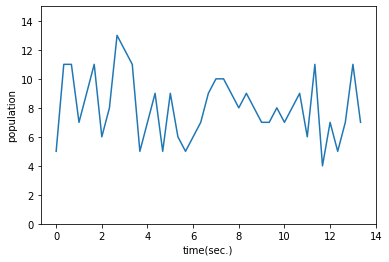

In [2]:
import matplotlib.pyplot as plt

plt.plot(list_df['time'], list_df['people'])
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0, 15)
plt.show()